# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z
Nz=len(zs)

In [4]:
undersample_z=3
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(undersample_z=undersample_z,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(undersample_z=undersample_z,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [5]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)


In [6]:
like=likelihood.Likelihood(data=data,theory=theory,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
ln_kF_0 = -1.70374859191
ln_kF_1 = 0
likelihood setup with 1 free parameters
1 free parameters


In [7]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414


In [8]:
# test likelihood function
values=[0.5]
like.log_prob(values=values)

0 2.2 model {'Delta2_p': 0.55651130145771688, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659957746, 'f_p': 0.96522452450210083, 'mF': 0.82678076324723049, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13069600926052841, 'kF_Mpc': 12.672154332566837}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.2994795015019927, 'alpha_p': -0.21637671767578953, 'f_p': 0.97065366319224333, 'mF': 0.79400932502668009, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12744692725288601, 'kF_Mpc': 12.995213267980114}
2 2.6 model {'Delta2_p': 0.44280074273630693, 'n_p': -2.2994793009304835, 'alpha_p': -0.21637578130992885, 'f_p': 0.97499691285123324, 'mF': 0.75832916245871795, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12436389094838281, 'kF_Mpc': 13.317370398835509}
3 2.8 model {'Delta2_p': 0.39841920050635804, 'n_p': -2.2994793725990892, 'alpha_p': -0.21637637290771081, 'f_p': 0.97850450521187982, 'mF': 0.71997791172041337, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12144623367196278, 'kF_Mpc': 13.6

-13204.571424225991

In [9]:
#cProfile.run("like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [10]:
def log_prob(values,like,verbose=False):
    test_log_prob=like.log_prob(values=values)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [11]:
like.go_silent()

In [12]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[log_prob([x],like) for x in xs]

-1.5 < ln_tau_0 < -0.4
0.223130160148 < tau_0 < 0.670320046036
0.511544833689 < <F> < 0.800010713004


Text(0, 0.5, '$\\chi^2$')

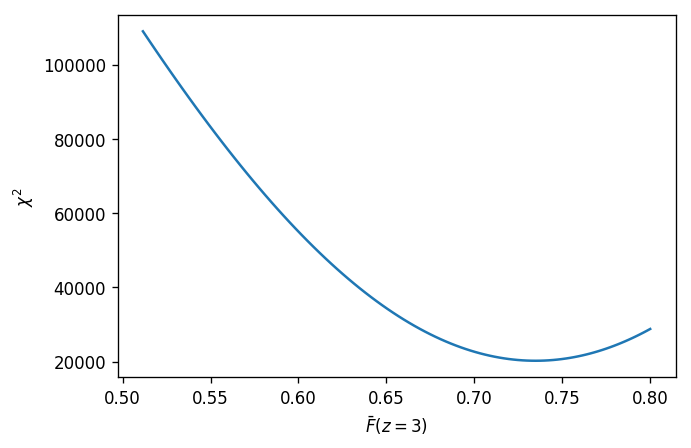

In [13]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [14]:
# for now we'll have only one dimension (mean flux)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [15]:
p0.flatten()

array([ 0.12919891,  0.90715195,  0.93397325,  0.68076326,  0.80536819,
        0.85272349,  0.7232093 ,  0.60990645,  0.43200558,  0.85348146])

In [16]:
# test function
log_prob(p0[0],like)

-11620.984914499379

In [17]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like])

In [18]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [ 0.29238673  0.30164542  0.29063517  0.28938445  0.2925074   0.29126824
  0.29296708  0.29353052  0.29457574  0.29585644] [-10129.40890303 -10133.53361434 -10129.84122268 -10130.38391413
 -10129.39323388 -10129.64078157 -10129.35022206 -10129.33360904
 -10129.40821806 -10129.6868552 ]


In [19]:
# reset and run actual chains
sampler.reset()
nsteps=200
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0].flatten())

0 [ 0.29241825  0.30164542  0.2873016   0.28967596  0.29209897  0.2910175
  0.29319846  0.2934711   0.29580327  0.296105  ]
20 [ 0.29517595  0.29561697  0.29619974  0.29378655  0.29715711  0.29697519
  0.29891705  0.29336637  0.29469674  0.28935802]
40 [ 0.2943233   0.29505757  0.2930151   0.29008847  0.29242443  0.29182087
  0.29647075  0.29058346  0.29364107  0.29346375]
60 [ 0.29438761  0.29122351  0.29364137  0.29662205  0.29093138  0.29683842
  0.29233985  0.2930914   0.29112699  0.2913639 ]
80 [ 0.29434669  0.29217239  0.29406712  0.29411165  0.29524043  0.2901094
  0.29275078  0.2907563   0.29280664  0.29236042]
100 [ 0.29821923  0.29517345  0.29306564  0.29092322  0.29233085  0.2910197
  0.29242531  0.29340255  0.29000854  0.29204411]
120 [ 0.29706936  0.29159673  0.29336235  0.29025084  0.29210256  0.29385918
  0.29009764  0.2924677   0.29096089  0.29258094]
140 [ 0.29371767  0.29342332  0.29234345  0.29293317  0.29715199  0.29170098
  0.29232038  0.291664    0.2906145   0.290

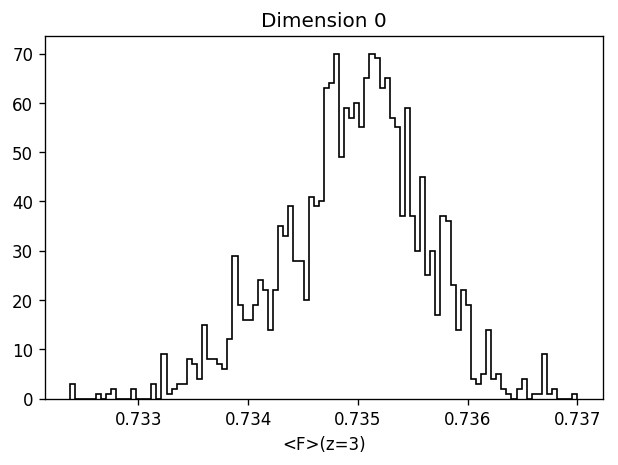

In [20]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [21]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.827


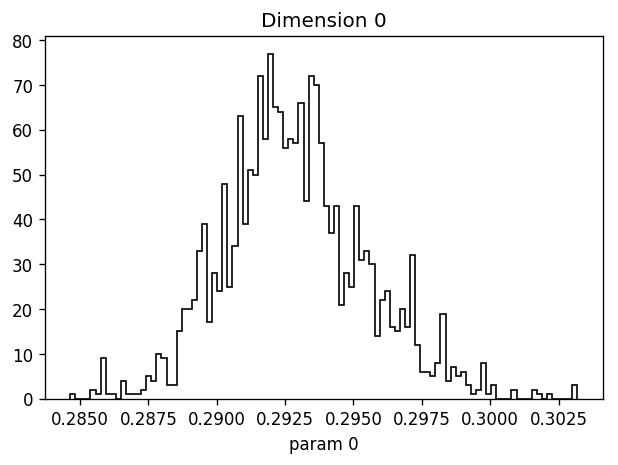

In [22]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))